## Project Overview

For this project, you will use multiple linear regression modeling to analyze house sales in a northwestern county.

### Business Problem

It is up to you to define a stakeholder and business problem appropriate to this dataset.

If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.


# Data


1. This project uses the **King County House Sales dataset** in  `data/kc_house_data.csv` in the data folder
2. The description of the column names in `data/column_names.md` in the same folder. 

- The column names are not perfectly described, so you'll have to do some research or use your best judgment if you have questions about what the data means.

- It is up to you to decide what data from this dataset to use and how to use it. **If you are feeling overwhelmed or behind**, we recommend you **ignore** some or all of the following features:

* `date`
* `view`
* `sqft_above`
* `sqft_basement`
* `yr_renovated`
* `address`
* `lat`
* `long`

# Key Points

* **Your goal in regression modeling is to yield findings to support relevant recommendations. Those findings should include a metric describing overall model performance as well as at least two regression model coefficients.** As you explore the data and refine your stakeholder and business problem definitions, make sure you are also thinking about how a linear regression model adds value to your analysis. "The assignment was to use linear regression" is not an acceptable answer! You can also use additional statistical techniques other than linear regression, so long as you clearly explain why you are using each technique.

* **You should demonstrate an iterative approach to modeling.** This means that you must build multiple models. Begin with a basic model, evaluate it, and then provide justification for and proceed to a new model. After you finish refining your models, you should provide 1-3 paragraphs in the notebook discussing your final model.

* **Data visualization and analysis are still very important.** In Phase 1, your project stopped earlier in the CRISP-DM process. Now you are going a step further, to modeling. Data visualization and analysis will help you build better models and tell a better story to your stakeholders.

## Getting Started

Please start by reviewing the contents of this project description. If you have any questions, please ask your instructor ASAP.

Next, you will need to complete the [***Project Proposal***](#project_proposal) which must be reviewed by your instructor before you can continue with the project.

Here are some suggestions for creating your GitHub repository:

1. Fork the [Phase 2 Project Repository](https://github.com/learn-co-curriculum/dsc-phase-2-project-v2-5), clone it locally, and work in the `student.ipynb` file. Make sure to also add and commit a PDF of your presentation to your repository with a file name of `presentation.pdf`.
2. Or, create a new repository from scratch by going to [github.com/new](https://github.com/new) and copying the data files from the Phase 2 Project Repository into your new repository.
   - Recall that you can refer to the [Phase 1 Project Template](https://github.com/learn-co-curriculum/dsc-project-template) as an example structure
   - This option will result in the most professional-looking portfolio repository, but can be more complicated to use. So if you are getting stuck with this option, try forking the project repository instead


# CRISP-DM

![crisp-dm-pic](./images/CRISP-DM.jpg)

# CRISP-DM Part 1: Business Understanding

### Real Estate Agency going to advise on one of the following:
1. Advise homeowners on types of homes to buy and/or sell
2. Advise homeowners on renovations to increase the value of their home

#### Since we have some freedom on our Business Understanding, we're going to get a better picture of our Data before deciding on a business problem and stakeholder

___

# CRISP-DM Part 2: Data Understanding

# %load data/column_names.md
# Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.


### Condition Column info:

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

### Grade Column Info:

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('data/kc_house_data.csv')

In [25]:
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  int64  
 9   greenbelt      30155 non-null  int64  
 10  nuisance       30155 non-null  int64  
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  int64  
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [20]:
# drop any Duplicate Rows
df_clean = df.drop_duplicates()
df_clean.info()

#### heat_source and sewer system have null values
#### need to explore the object type columns, get their dummy values and find out if they correlate.

[King County Coordinates and Zipcode info](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)

In [19]:
df_zip['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b')

### #zip codes taken from this site : [Zip-Codes.com](https://www.zip-codes.com/county/wa-king.asp#:~:text=KING%20County%2C%20WA%20Covers%20120%20ZIP%20Codes%20,%20%20425%20%2035%20more%20rows%20)

In [1]:
data = """
ZIP Code 98001	General	Auburn	31,911	Pacific	253
ZIP Code 98002	General	Auburn	31,647	Pacific	253
ZIP Code 98003	General	Federal Way	44,151	Pacific	253
ZIP Code 98004	General	Bellevue	27,946	Pacific	425
ZIP Code 98005	General	Bellevue	17,714	Pacific	425
ZIP Code 98006	General	Bellevue	36,364	Pacific	425
ZIP Code 98007	General	Bellevue	24,889	Pacific	425
ZIP Code 98008	General	Bellevue	24,411	Pacific	425
ZIP Code 98009	P.O. Box	Bellevue	0	Pacific	425
ZIP Code 98010	General	Black Diamond	5,025	Pacific	360/564
ZIP Code 98011	General	Bothell	29,212	Pacific	425
ZIP Code 98013	P.O. Box	Burton	0	Pacific	206
ZIP Code 98014	General	Carnation	6,765	Pacific	425
ZIP Code 98015	P.O. Box	Bellevue	0	Pacific	425
ZIP Code 98019	General	Duvall	10,725	Pacific	425
ZIP Code 98022	General	Enumclaw	20,987	Pacific	360/564
ZIP Code 98023	General	Federal Way	47,510	Pacific	253
ZIP Code 98024	General	Fall City	5,650	Pacific	425
ZIP Code 98025	P.O. Box	Hobart	0	Pacific	425
ZIP Code 98027	General	Issaquah	26,141	Pacific	425
ZIP Code 98028	General	Kenmore	20,419	Pacific	425
ZIP Code 98029	General	Issaquah	24,348	Pacific	425
ZIP Code 98030	General	Kent	33,769	Pacific	253
ZIP Code 98031	General	Kent	36,581	Pacific	253/425
ZIP Code 98032	General	Kent	33,853	Pacific	253/425
ZIP Code 98033	General	Kirkland	34,338	Pacific	425/206
ZIP Code 98034	General	Kirkland	40,407	Pacific	425/206
ZIP Code 98035	P.O. Box	Kent	0	Pacific	253/425
ZIP Code 98038	General	Maple Valley	31,171	Pacific	425
ZIP Code 98039	General	Medina	2,971	Pacific	425
ZIP Code 98040	General	Mercer Island	22,699	Pacific	206
ZIP Code 98041	P.O. Box	Bothell	0	Pacific	425
ZIP Code 98042	General	Kent	43,673	Pacific	253/425
ZIP Code 98045	General	North Bend	13,888	Pacific	425
ZIP Code 98047	General	Pacific	6,339	Pacific	253
ZIP Code 98050	P.O. Box	Preston	322	Pacific	425
ZIP Code 98051	General	Ravensdale	3,270	Pacific	360/564
ZIP Code 98052	General	Redmond	58,442	Pacific	206/425
ZIP Code 98053	General	Redmond	18,784	Pacific	425/206
ZIP Code 98055	General	Renton	21,904	Pacific	425
ZIP Code 98056	General	Renton	32,489	Pacific	425
ZIP Code 98057	General	Renton	10,613	Pacific	425
ZIP Code 98058	General	Renton	41,938	Pacific	425
ZIP Code 98059	General	Renton	34,463	Pacific	425
ZIP Code 98062	P.O. Box	Seahurst	0	Pacific	206/253
ZIP Code 98063	P.O. Box	Federal Way	0	Pacific	253
ZIP Code 98064	P.O. Box	Kent	0	Pacific	253/425
ZIP Code 98065	General	Snoqualmie	12,699	Pacific	425
ZIP Code 98070	General	Vashon	10,624	Pacific	206
ZIP Code 98071	P.O. Box	Auburn	0	Pacific	253
ZIP Code 98072	General	Woodinville	22,312	Pacific	425
ZIP Code 98073	P.O. Box	Redmond	0	Pacific	206/425
ZIP Code 98074	General	Sammamish	25,748	Pacific	425/206
ZIP Code 98075	General	Sammamish	20,715	Pacific	425
ZIP Code 98077	General	Woodinville	13,585	Pacific	425
ZIP Code 98083	P.O. Box	Kirkland	0	Pacific	425/206
ZIP Code 98089	P.O. Box	Kent	0	Pacific	253/425
ZIP Code 98092	General	Auburn	39,816	Pacific	253
ZIP Code 98093	P.O. Box	Federal Way	0	Pacific	253
ZIP Code 98101	General	Seattle	10,238	Pacific	206/253/360/425/564
ZIP Code 98102	General	Seattle	20,756	Pacific	206/360/425/564
ZIP Code 98103	General	Seattle	45,911	Pacific	206
ZIP Code 98104	General	Seattle	13,095	Pacific	206/253/360/425/564
ZIP Code 98105	General	Seattle	43,924	Pacific	206
ZIP Code 98106	General	Seattle	22,873	Pacific	206
ZIP Code 98107	General	Seattle	21,147	Pacific	206
ZIP Code 98108	General	Seattle	22,374	Pacific	206
ZIP Code 98109	General	Seattle	20,715	Pacific	206/425
ZIP Code 98111	P.O. Box	Seattle	0	Pacific	206/425
ZIP Code 98112	General	Seattle	21,077	Pacific	206/425
ZIP Code 98113	P.O. Box	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98114	P.O. Box	Seattle	0	Pacific	206/425
ZIP Code 98115	General	Seattle	46,206	Pacific	206
ZIP Code 98116	General	Seattle	22,241	Pacific	206
ZIP Code 98117	General	Seattle	31,365	Pacific	206
ZIP Code 98118	General	Seattle	42,731	Pacific	206
ZIP Code 98119	General	Seattle	21,039	Pacific	206
ZIP Code 98121	General	Seattle	12,628	Pacific	206/360/425/564
ZIP Code 98122	General	Seattle	31,454	Pacific	206/425
ZIP Code 98124	P.O. Box	Seattle	0	Pacific	206/425
ZIP Code 98125	General	Seattle	37,081	Pacific	206
ZIP Code 98126	General	Seattle	20,698	Pacific	206
ZIP Code 98127	P.O. Box	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98129	Unique	Seattle	0	Pacific	206/425
ZIP Code 98131	General	Seattle	0	Pacific	206
ZIP Code 98133	General	Seattle	44,555	Pacific	206/425
ZIP Code 98134	General	Seattle	644	Pacific	206
ZIP Code 98136	General	Seattle	14,770	Pacific	206
ZIP Code 98138	P.O. Box	Seattle	0	Pacific	206/425
ZIP Code 98139	P.O. Box	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98141	P.O. Box	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98144	General	Seattle	26,881	Pacific	206
ZIP Code 98145	P.O. Box	Seattle	0	Pacific	206/425
ZIP Code 98146	General	Seattle	25,922	Pacific	206/253
ZIP Code 98148	General	Seattle	10,010	Pacific	206/253
ZIP Code 98154	General	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98155	General	Seattle	32,778	Pacific	206/425
ZIP Code 98158	General	Seattle	0	Pacific	206
ZIP Code 98160	P.O. Box	Seattle	0	Pacific	206/425
ZIP Code 98161	General	Seattle	0	Pacific	206/425
ZIP Code 98164	General	Seattle	141	Pacific	206/425
ZIP Code 98165	P.O. Box	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98166	General	Seattle	20,301	Pacific	206/253
ZIP Code 98168	General	Seattle	33,734	Pacific	206/425/253
ZIP Code 98170	Unique	Seattle	0	Pacific	206/425
ZIP Code 98174	General	Seattle	0	Pacific	206/425
ZIP Code 98175	P.O. Box	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98177	General	Seattle	19,030	Pacific	206/425
ZIP Code 98178	General	Seattle	24,092	Pacific	425/206/253
ZIP Code 98181	Unique	Seattle	0	Pacific	206/425
ZIP Code 98185	Unique	Seattle	0	Pacific	206/425
ZIP Code 98188	General	Seattle	23,111	Pacific	425/206/253
ZIP Code 98190	Unique	Seattle	0	Pacific	206/425
ZIP Code 98191	Unique	Seattle	0	Pacific	206/425
ZIP Code 98194	P.O. Box	Seattle	0	Pacific	206/253/360/425/564
ZIP Code 98195	Unique	Seattle	0	Pacific	206
ZIP Code 98198	General	Seattle	34,584	Pacific	206/253
ZIP Code 98199	General	Seattle	19,686	Pacific	206
ZIP Code 98224	P.O. Box	Baring	294	Pacific	425
ZIP Code 98288	P.O. Box	Skykomish	333	Pacific	425
"""


zip_codes = []
for line in data.split("\n"):
    if "ZIP Code" in line:
        zip_code = int(line.split("ZIP Code ")[1].split()[0])
        zip_codes.append(zip_code)

In [20]:
df_zip_check = df_zip[df_zip['zipcode'].isin(zip_codes)==False]

In [24]:
df_zip_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29239 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29239 non-null  int64  
 1   date           29239 non-null  object 
 2   price          29239 non-null  float64
 3   bedrooms       29239 non-null  int64  
 4   bathrooms      29239 non-null  float64
 5   sqft_living    29239 non-null  int64  
 6   sqft_lot       29239 non-null  int64  
 7   floors         29239 non-null  float64
 8   waterfront     29239 non-null  object 
 9   greenbelt      29239 non-null  object 
 10  nuisance       29239 non-null  object 
 11  view           29239 non-null  object 
 12  condition      29239 non-null  object 
 13  grade          29239 non-null  object 
 14  heat_source    29209 non-null  object 
 15  sewer_system   29226 non-null  object 
 16  sqft_above     29239 non-null  int64  
 17  sqft_basement  29239 non-null  int64  
 18  sqft_g

In [22]:
df_view = df_zip_check[(df_zip_check['lat'] >= 46.71) 
                       & (df_zip_check['lat'] <= 48.31) 
                       & (df_zip_check['long'] >= -123.07) 
                       & (df_zip_check['long'] <= -119.90)]
df_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29239 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29239 non-null  int64  
 1   date           29239 non-null  object 
 2   price          29239 non-null  float64
 3   bedrooms       29239 non-null  int64  
 4   bathrooms      29239 non-null  float64
 5   sqft_living    29239 non-null  int64  
 6   sqft_lot       29239 non-null  int64  
 7   floors         29239 non-null  float64
 8   waterfront     29239 non-null  object 
 9   greenbelt      29239 non-null  object 
 10  nuisance       29239 non-null  object 
 11  view           29239 non-null  object 
 12  condition      29239 non-null  object 
 13  grade          29239 non-null  object 
 14  heat_source    29209 non-null  object 
 15  sewer_system   29226 non-null  object 
 16  sqft_above     29239 non-null  int64  
 17  sqft_basement  29239 non-null  int64  
 18  sqft_g

In [5]:
df_view['zipcode'] = df_view['address'].str.extract(r'\b(\d{5})[,]\s*United States\b')
df_view

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,11/30/2021,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940,98103
30151,194000695,6/16/2021,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851,98116
30152,7960100080,5/27/2022,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585,98122
30153,2781280080,2/24/2022,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908,98055


<AxesSubplot:>

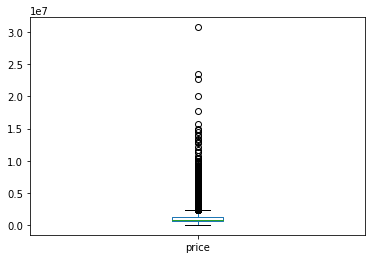

In [26]:
df_view['price'].plot(kind='box')

In [71]:
df_view['price'].sort_values(ascending=False).head(25)

23470    30750000.0
3760     23500000.0
25561    22750000.0
27175    20000000.0
18100    17800000.0
9516     15740000.0
10605    15000001.0
8054     14850000.0
22707    14500000.0
5811     13950000.0
12817    13850000.0
8656     13425000.0
6106     13300000.0
16673    12932174.0
6936     12901148.0
22605    12750000.0
12712    12125000.0
20496    11625000.0
11464    11400000.0
24262    11300000.0
21840    10750000.0
22720    10500000.0
18628    10500000.0
26617    10300000.0
20831    10030000.0
Name: price, dtype: float64

In [31]:
df_view_no_out = df_view.loc[df_view['price'] <= 1882000]
df_view_no_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26089 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26089 non-null  int64  
 1   date           26089 non-null  object 
 2   price          26089 non-null  float64
 3   bedrooms       26089 non-null  int64  
 4   bathrooms      26089 non-null  float64
 5   sqft_living    26089 non-null  int64  
 6   sqft_lot       26089 non-null  int64  
 7   floors         26089 non-null  float64
 8   waterfront     26089 non-null  object 
 9   greenbelt      26089 non-null  object 
 10  nuisance       26089 non-null  object 
 11  view           26089 non-null  object 
 12  condition      26089 non-null  object 
 13  grade          26089 non-null  object 
 14  heat_source    26060 non-null  object 
 15  sewer_system   26079 non-null  object 
 16  sqft_above     26089 non-null  int64  
 17  sqft_basement  26089 non-null  int64  
 18  sqft_g

<AxesSubplot:>

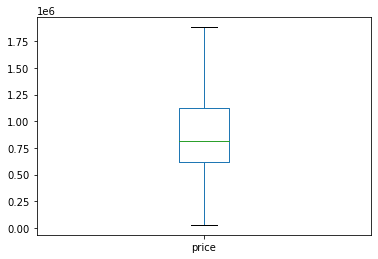

In [32]:
df_view_no_out['price'].plot(kind='box')

<AxesSubplot:ylabel='Frequency'>

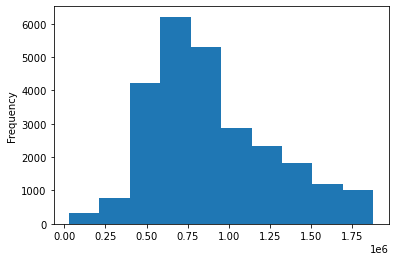

In [33]:
df_view_no_out['price'].plot(kind='hist', )

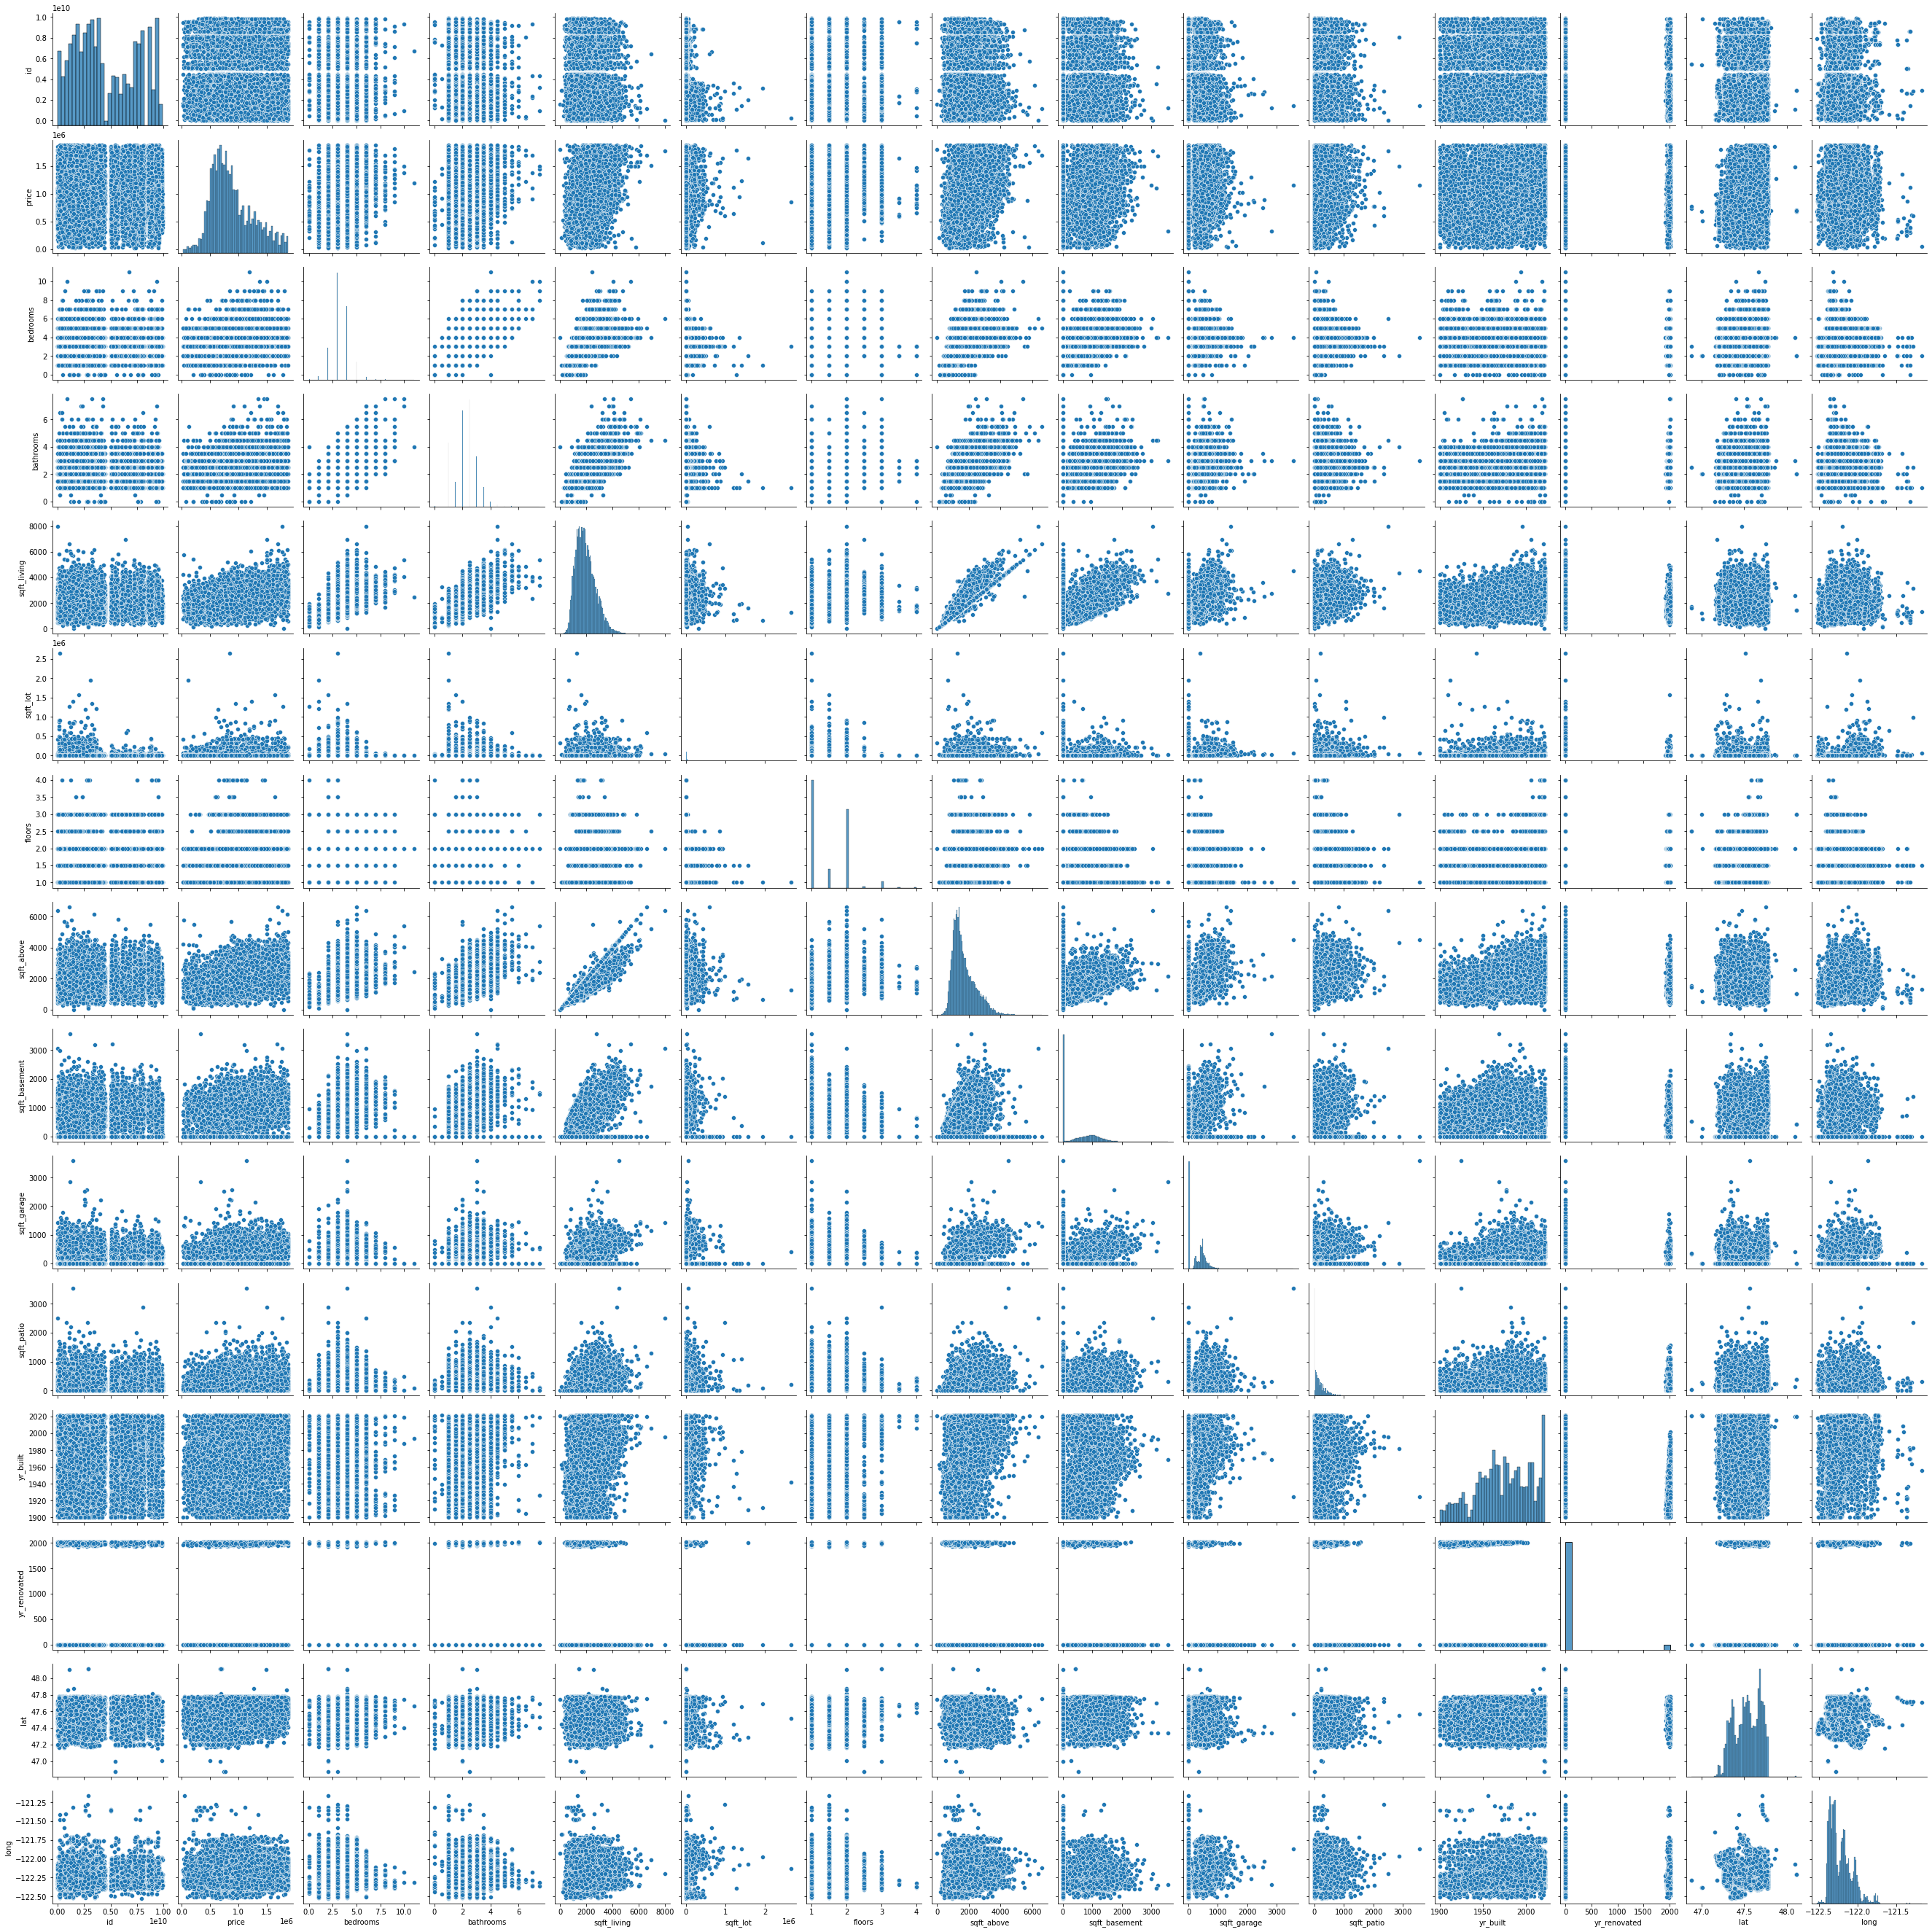

In [37]:
sns.pairplot(df_view_no_out)

### Column Exploration:

#### 1. Waterfront 

In [34]:
df['waterfront'].value_counts()

NO     29636
YES      519
Name: waterfront, dtype: int64

In [35]:
df['greenbelt'].value_counts()

NO     29382
YES      773
Name: greenbelt, dtype: int64

In [36]:
df['nuisance'].value_counts()

NO     24893
YES     5262
Name: nuisance, dtype: int64

In [22]:
df['view'].value_counts()

NONE         26589
AVERAGE       1915
GOOD           878
EXCELLENT      553
FAIR           220
Name: view, dtype: int64

#### need to find correlation to price. If correlation need to find out how the scale works
#### Will also want to checkout to see that the lattitude and longitude of these views makes sense. Views that fall into each category should be relatively close to each other, thus having similar lattitudes and longitudes.

In [23]:
df['condition'].value_counts()

Average      18547
Good          8054
Very Good     3259
Fair           230
Poor            65
Name: condition, dtype: int64

#### need to find correlation to price. If correlation need to find out how the scale works

In [13]:
df['grade'].value_counts()

7 Average        11697
8 Good            9410
9 Better          3806
6 Low Average     2858
10 Very Good      1371
11 Excellent       406
5 Fair             393
12 Luxury          122
4 Low               51
13 Mansion          24
3 Poor              13
2 Substandard        2
1 Cabin              2
Name: grade, dtype: int64

#### need to find correlation to price. If correlation need to find out how the scale works

In [25]:
df['heat_source'].value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

#### need to find correlation to price. If correlation need to find out how the scale works

In [26]:
df['sewer_system'].value_counts()

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

#### need to find correlation to price. If correlation need to find out how the scale works

#### probably going to split this column by street and zip. Have to make sure that it matches up with lat and long

### Column Types to be converted:
- date: object ---> datetime
- waterfront: object ---> boolean


In [19]:
# convert 'date' column to datetime format (date only)
df['date'] = pd.to_datetime(df['date']).dt.date
df['date']

0        2022-05-24
1        2021-12-13
2        2021-09-29
3        2021-12-14
4        2021-08-24
            ...    
30150    2021-11-30
30151    2021-06-16
30152    2022-05-27
30153    2022-02-24
30154    2022-04-29
Name: date, Length: 30155, dtype: object

In [21]:
# lambda function to extract the first character of each object and convert it to an int.
#extract_num = lambda x: int(x[0])

# Apply the lambda function
#df['grade'] = df['grade'].apply(extract_num)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  int64  
 9   greenbelt      30155 non-null  int64  
 10  nuisance       30155 non-null  int64  
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  int64  
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [29]:
sorted_df = df[['address', 'lat', 'long']].sort_values('lat', ascending=False)
sorted_df

,address,lat,long
8024,"25th Avenue, Fairbanks, Alaska 99701, United S...",64.824070,-147.728320
16608,"236 Beaver Boulevard, North Pole, Alaska 99705...",64.752684,-147.337806
15265,"6309 East 9th Avenue, Anchorage, Alaska 99504,...",61.213802,-149.763229
11642,"6317 East 9th Avenue, Anchorage, Alaska 99504,...",61.213802,-149.763047
27872,"1727 West 15th Avenue, Anchorage, Alaska 99501...",61.207910,-149.917070
...,...,...,...
9883,"2952 Northwest 85th Street, Miami, Florida 331...",25.851697,-80.237788
6333,"2950 Northwest 85th Street, Miami, Florida 331...",25.851697,-80.237786
15135,"830 Northeast 79th Street, Miami, Florida 3313...",25.847715,-80.179830
24803,"21st Avenue, Honolulu, Hawaii 96816, United St...",21.274240,-157.791480


## Categorizing columns in an effort to split up the data

In [ ]:

yr_built - Year when house was built
yr_renovated - Year when house was renovated
address - The street address
lat - Latitude coordinate
long - Longitude coordinate
Most fields were pulled from the King County Assessor Data Download.

The address, lat, and long fields have been retrieved using a third-party geocoding API. In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the address, lat, or long fields in your modeling, consider identifying outliers prior to including the values in your model.

In [ ]:
 0   id             30155 non-null  int64  #primary key
 2   price          30155 non-null  float64 #our data analysis target metric
    
 1   date           30155 non-null  object #date house sold (time)
 20  yr_built       30155 non-null  int64  # Year when house was built (time/constant)
 21  yr_renovated   30155 non-null  int64  # year when house was renovated (time/constant)

 8   waterfront     30155 non-null  object # Whether the house is on a waterfront (location/constant) (bool)
 9   greenbelt      30155 non-null  object # Whether the house is adjacent to a green belt (location/constant) (bool)
 10  nuisance       30155 non-null  object # Whether the house has traffic noise or other recorded nuisances (location/constant) (bool)
 11  view           30155 non-null  object # Quality of view from house (location/constant) (categorical)
 22  address        30155 non-null  object # address of house (location/constant) (categorical)
 23  lat            30155 non-null  float64 #lattitude coordinate (location/constant)
 24  long           30155 non-null  float64 #longitude coordinate (location/constant)    
    
 6   sqft_lot       30155 non-null  int64  # Square footage of the lot (feature/constant)   
 15  sewer_system   30141 non-null  object # Sewer system for the house (feature/constant) Note: could change but not rly
       
 3   bedrooms       30155 non-null  int64  # number of bedrooms (feature/changeable)
 4   bathrooms      30155 non-null  float64 # number of full and half bathrooms (feature/changeable)
 7   floors         30154 non-null  float64 # number of floors/levels of house (feature/changeable)
 14  heat_source    30123 non-null  object # Heat source for the house (feature/chageable)
    
 12  condition      30155 non-null  object # How good the overall condition of the house is (descriptive)
 13  grade          30155 non-null  object # Overall grade of the house (descriptive)
       
 16  sqft_above     30155 non-null  int64  # Square footage of house apart from basement (feature)
 17  sqft_basement  30155 non-null  int64  # Square footage of the basement (feature)
 18  sqft_garage    30155 non-null  int64  # Square footage of garage space (feature)
 19  sqft_patio     30155 non-null  int64  # Square footage of outdoor porch or deck space (feature)
 5   sqft_living    30155 non-null  int64  # Square footage of living space in the home (feature)